<a href="https://colab.research.google.com/github/Leo-997/-2024-T2-COMP9517-Group-try-to-best/blob/Master/9444_Home.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<div align="center">

| Name    | Student ID |
|---------|------------|
| Ziqi Wu | 14215584   |
| sss     | s1231      |
| sss     | s1231      |
| sss     | s1231      |
| Yongyi Xu  | z5499298   |
</div>

RNN

d:\python3.8\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Epoch 1/30, Train Loss: 1.6142, Train Accuracy: 0.3123, Validation Loss: 1.5886, Validation Accuracy: 0.3625
Epoch 2/30, Train Loss: 1.5849, Train Accuracy: 0.3468, Validation Loss: 1.5307, Validation Accuracy: 0.4105
Epoch 3/30, Train Loss: 1.5164, Train Accuracy: 0.4083, Validation Loss: 1.4939, Validation Accuracy: 0.4405
Epoch 4/30, Train Loss: 1.4312, Train Accuracy: 0.4579, Validation Loss: 1.4212, Validation Accuracy: 0.4645
Epoch 5/30, Train Loss: 1.3412, Train Accuracy: 0.5051, Validation Loss: 1.3658, Validation Accuracy: 0.5160
Epoch 6/30, Train Loss: 1.2607, Train Accuracy: 0.5481, Validation Loss: 1.2850, Validation Accuracy: 0.5535
Epoch 7/30, Train Loss: 1.1836, Train Accuracy: 0.5840, Validation Loss: 1.2570, Validation Accuracy: 0.5635
Epoch 8/30, Train Loss: 1.1073, Train Accuracy: 0.6090, Validation Loss: 1.2425, Validation Accuracy: 0.5540
Epoch 9/30, Train Loss: 1.0309, Train Accuracy: 0.6438, Validation Loss: 1.1538, Validation Accuracy: 0.6135
Epoch 10/30, Train 

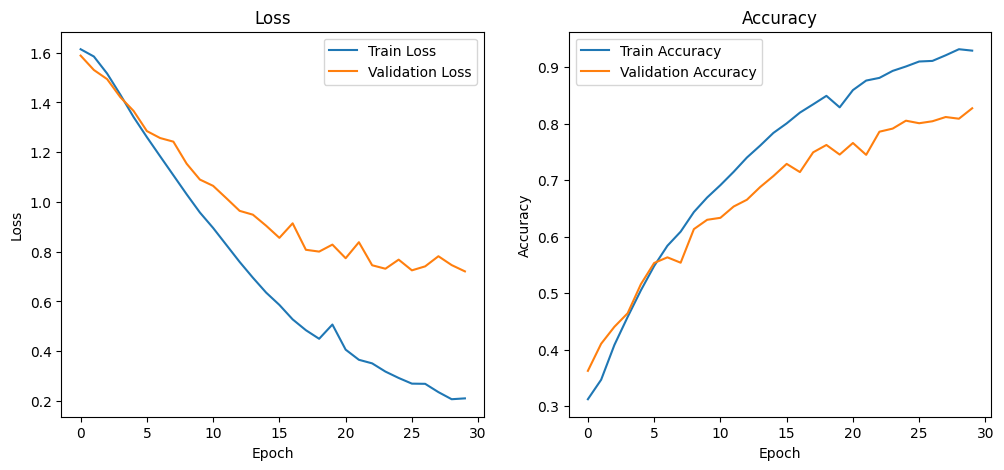

Test Accuracy: 0.7915
              precision    recall  f1-score   support

     sadness       0.81      0.90      0.85       581
         joy       0.84      0.85      0.85       695
        love       0.57      0.50      0.53       159
       anger       0.81      0.71      0.76       275
        fear       0.78      0.73      0.76       224
    surprise       0.48      0.41      0.44        66

    accuracy                           0.79      2000
   macro avg       0.72      0.68      0.70      2000
weighted avg       0.79      0.79      0.79      2000



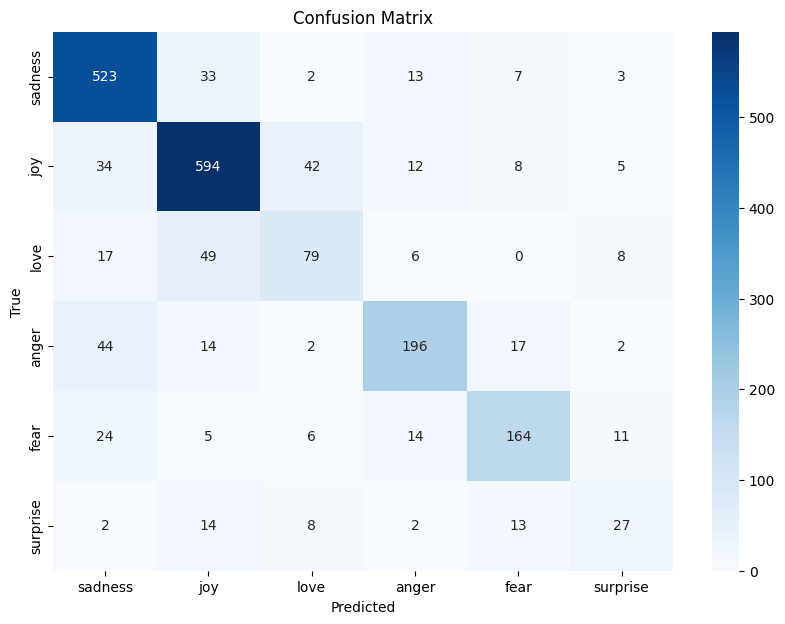

In [ ]:
import torch
from datasets import load_dataset
import re
from torch import nn
from transformers import BertTokenizer
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load dataset
dataset = load_dataset("dair-ai/emotion", "split")
train_dataset = dataset['train']
val_dataset = dataset['validation']
test_dataset = dataset['test']

# Text preprocessing function
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'\s+', ' ', text).strip()
    return text

# Process training, validation, and test datasets
train_texts = [preprocess_text(text) for text in train_dataset['text']]
val_texts = [preprocess_text(text) for text in val_dataset['text']]
test_texts = [preprocess_text(text) for text in test_dataset['text']]

# Labels
train_labels = train_dataset['label']
val_labels = val_dataset['label']
test_labels = test_dataset['label']

# Load BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Data encoding function
def encode_data(texts, labels, tokenizer, max_length=128):
    inputs = tokenizer(texts, padding=True, truncation=True, max_length=max_length, return_tensors="pt")
    inputs["labels"] = torch.tensor(labels)
    return inputs

# Encode training, validation, and test datasets
train_encodings = encode_data(train_texts, train_labels, tokenizer)
val_encodings = encode_data(val_texts, val_labels, tokenizer)
test_encodings = encode_data(test_texts, test_labels, tokenizer)

# Define multi-layer bidirectional RNN model
class RNNModel(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, num_labels, num_layers=2, dropout=0.5):
        super(RNNModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.rnn = nn.RNN(embed_dim, hidden_dim, num_layers=num_layers, bidirectional=True, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_dim * 2, num_labels)  # hidden_dim * 2 because of bidirectional
        self.dropout = nn.Dropout(dropout)

    def forward(self, input_ids):
        embedded = self.embedding(input_ids)
        output, hidden = self.rnn(embedded)
        out = self.dropout(hidden[-2:].transpose(0, 1).contiguous().view(hidden.size(1), -1))  # concatenate last forward and backward hidden states
        logits = self.fc(out)
        return logits

# Get vocabulary size
vocab_size = tokenizer.vocab_size

# Define model
model = RNNModel(vocab_size, embed_dim=128, hidden_dim=256, num_labels=6, num_layers=2, dropout=0.5)
model.to(device)  # Move model to GPU

# Define dataset class
class EmotionDataset(torch.utils.data.Dataset):
    def __init__(self, encodings):
        self.encodings = encodings
    def __getitem__(self, idx):
        return {key: val[idx] for key, val in self.encodings.items()}
    def __len__(self):
        return len(self.encodings['input_ids'])

# Training function with early stopping
def train_model(model, train_dataset, val_dataset, epochs, batch_size, learning_rate, patience):
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []
    best_val_loss = float('inf')
    patience_counter = 0

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        correct = 0
        total = 0
        for batch in train_loader:
            input_ids = batch['input_ids'].to(device)
            labels = batch['labels'].to(device)
            optimizer.zero_grad()
            outputs = model(input_ids)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        train_loss = total_loss / len(train_loader)
        train_accuracy = correct / total
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)
        model.eval()
        val_loss = 0
        correct = 0
        total = 0
        with torch.no_grad():
            for batch in val_loader:
                input_ids = batch['input_ids'].to(device)
                labels = batch['labels'].to(device)
                outputs = model(input_ids)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        val_loss = val_loss / len(val_loader)
        val_accuracy = correct / total
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)
        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")

        # Early stopping mechanism
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            torch.save(model.state_dict(), "best_model.pth")
        else:
            patience_counter += 1

        if patience_counter >= patience:
            print("Early stopping triggered")
            break

    # Plot loss and accuracy graphs
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Loss')

    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label='Train Accuracy')
    plt.plot(val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Accuracy')
    plt.show()

def evaluate_model(model, test_dataset):
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=16)
    model.eval()
    correct = 0
    total = 0
    predictions = []
    true_labels = []
    with torch.no_grad():
        for batch in test_loader:
            input_ids = batch['input_ids'].to(device)
            labels = batch['labels'].to(device)
            outputs = model(input_ids)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            predictions.extend(predicted.tolist())
            true_labels.extend(labels.tolist())
    print(f"Test Accuracy: {correct / total}")
    print(classification_report(true_labels, predictions, target_names=['sadness', 'joy', 'love', 'anger', 'fear', 'surprise']))
    cm = confusion_matrix(true_labels, predictions)
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['sadness', 'joy', 'love', 'anger', 'fear', 'surprise'], yticklabels=['sadness', 'joy', 'love', 'anger', 'fear', 'surprise'])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

# Train the model with early stopping patience set to 5
train_model(model, EmotionDataset(train_encodings), EmotionDataset(val_encodings), epochs=30, batch_size=16, learning_rate=0.0001, patience=5)

def save_model(model, path):
    torch.save(model.state_dict(), path)

# Load model parameters
def load_model(model, path):
    model.load_state_dict(torch.load(path))
    model.to(device)  # Ensure the model is moved to the GPU
    model.eval()
    return model

# Save the model
save_model(model, "rnn_model.pth")

# Define a new model instance and load the saved parameters
model_loaded = RNNModel(vocab_size, embed_dim=128, hidden_dim=256, num_labels=6, num_layers=2, dropout=0.5)
model_loaded = load_model(model_loaded, "rnn_model.pth")

# Evaluate the model on the test dataset
evaluate_model(model_loaded, EmotionDataset(test_encodings))


Glove

[=================---------------------------------] 35.5% 23.4/66.0MB downloaded

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



[==========================================--------] 84.1% 55.5/66.0MB downloaded

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



[==================================================] 100.0% 66.0/66.0MB downloaded
GPU device not found. Training will be done on CPU.
Epoch 1/30
500/500 [==============================] - 43s 79ms/step - loss: 1.5951 - accuracy: 0.3252 - val_loss: 1.5852 - val_accuracy: 0.3440
Epoch 2/30
500/500 [==============================] - 40s 79ms/step - loss: 1.5182 - accuracy: 0.3961 - val_loss: 1.3341 - val_accuracy: 0.5155
Epoch 3/30
500/500 [==============================] - 40s 81ms/step - loss: 1.2684 - accuracy: 0.5284 - val_loss: 1.1985 - val_accuracy: 0.5490
Epoch 4/30
500/500 [==============================] - 40s 80ms/step - loss: 1.1814 - accuracy: 0.5558 - val_loss: 1.0993 - val_accuracy: 0.6065
Epoch 5/30
500/500 [==============================] - 40s 81ms/step - loss: 1.0536 - accuracy: 0.6257 - val_loss: 0.9483 - val_accuracy: 0.6580
Epoch 6/30
500/500 [==============================] - 42s 83ms/step - loss: 0.8941 - accuracy: 0.6831 - val_loss: 0.7895 - val_accuracy: 0.7250
E

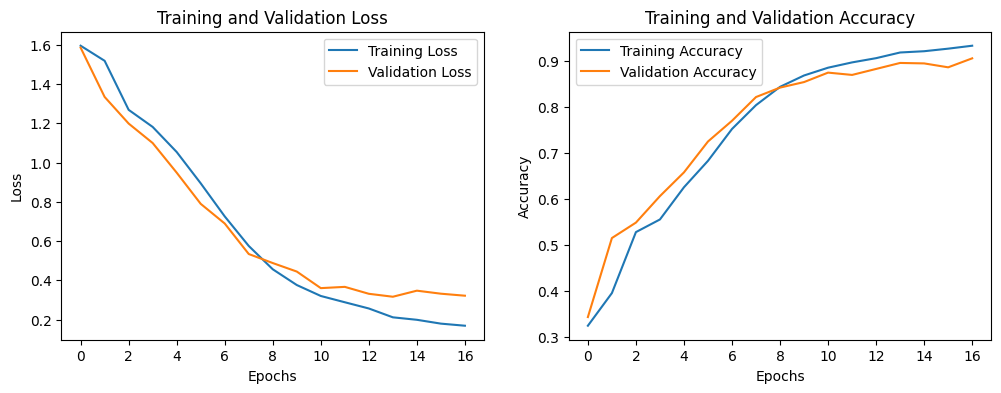

63/63 [==============================] - 2s 30ms/step - loss: 0.3699 - accuracy: 0.8805
Test Accuracy: 0.8805000185966492
63/63 [==============================] - 3s 28ms/step
              precision    recall  f1-score   support

     sadness       0.93      0.90      0.91       581
         joy       0.93      0.87      0.90       695
        love       0.72      0.90      0.80       159
       anger       0.90      0.88      0.89       275
        fear       0.87      0.87      0.87       224
    surprise       0.54      0.79      0.64        66

    accuracy                           0.88      2000
   macro avg       0.82      0.87      0.84      2000
weighted avg       0.89      0.88      0.88      2000



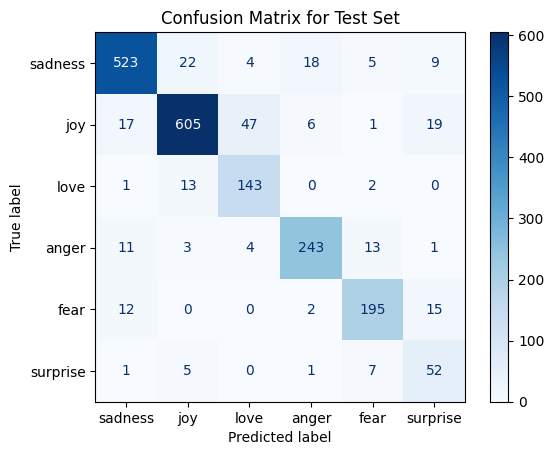

In [ ]:
import gensim.downloader as api
import numpy as np
from datasets import load_dataset
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import tensorflow as tf

# Load pre-trained GloVe vectors
glove_vectors = api.load("glove-wiki-gigaword-50")

# Define a function that converts text to GloVe embedding
def vectorize_sentence(sentence, model, max_len):
    words = sentence.split()
    word_vectors = [model[word] for word in words if word in model]
    return pad_sequences([word_vectors], maxlen=max_len, padding='post', dtype='float32')[0]

# Load dataset
dataset_split = load_dataset("dair-ai/emotion", name="split")

# Set maximum sequence length
max_len = 50

# Convert text to GloVe embeddings
train_texts = dataset_split['train']['text']
train_labels = dataset_split['train']['label']
train_vectors = np.array([vectorize_sentence(text, glove_vectors, max_len) for text in train_texts])

val_texts = dataset_split['validation']['text']
val_labels = dataset_split['validation']['label']
val_vectors = np.array([vectorize_sentence(text, glove_vectors, max_len) for text in val_texts])

test_texts = dataset_split['test']['text']
test_labels = dataset_split['test']['label']
test_vectors = np.array([vectorize_sentence(text, glove_vectors, max_len) for text in test_texts])

# Convert labels to one-hot encoding
train_labels = to_categorical(train_labels, num_classes=6)
val_labels = to_categorical(val_labels, num_classes=6)
test_labels = to_categorical(test_labels, num_classes=6)

# Build LSTM model
model = Sequential()
model.add(LSTM(128, input_shape=(max_len, 50), return_sequences=True))
model.add(Dropout(0.5))
model.add(LSTM(128))
model.add(Dropout(0.5))
model.add(Dense(6, activation='softmax'))

# Compile model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Check if GPU is available
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    print('GPU device not found. Training will be done on CPU.')
else:
    print('Found GPU at: {}'.format(device_name))

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Set device using tf.device()
with tf.device(device_name if device_name else '/cpu:0'):
    # Record training and validation loss and accuracy
    history = model.fit(train_vectors, train_labels, epochs=30, batch_size=32, validation_data=(val_vectors, val_labels), callbacks=[early_stopping])

model.save('lstm_glove_model.keras')

# Plot training and validation loss
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

# Evaluate model on test set
loss, accuracy = model.evaluate(test_vectors, test_labels)
print(f'Test Accuracy: {accuracy}')

# Predict on test set
predictions = model.predict(test_vectors)
predicted_labels = np.argmax(predictions, axis=1)
true_labels = np.argmax(test_labels, axis=1)

# Print detailed classification report
report = classification_report(true_labels, predicted_labels, target_names=['sadness', 'joy', 'love', 'anger', 'fear', 'surprise'])
print(report)

# Generate and display confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['sadness', 'joy', 'love', 'anger', 'fear', 'surprise'])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix for Test Set')
plt.show()


CNN

Epoch 1/40, Train Loss: 1.6794, Train Accuracy: 0.3129, Validation Loss: 1.5301, Validation Accuracy: 0.3950
Epoch 2/40, Train Loss: 1.5339, Train Accuracy: 0.3880, Validation Loss: 1.4642, Validation Accuracy: 0.4540
Epoch 3/40, Train Loss: 1.4447, Train Accuracy: 0.4347, Validation Loss: 1.3935, Validation Accuracy: 0.4765
Epoch 4/40, Train Loss: 1.3379, Train Accuracy: 0.4895, Validation Loss: 1.3003, Validation Accuracy: 0.5330
Epoch 5/40, Train Loss: 1.2263, Train Accuracy: 0.5489, Validation Loss: 1.1905, Validation Accuracy: 0.5785
Epoch 6/40, Train Loss: 1.1097, Train Accuracy: 0.5989, Validation Loss: 1.0797, Validation Accuracy: 0.6330
Epoch 7/40, Train Loss: 0.9874, Train Accuracy: 0.6502, Validation Loss: 0.9645, Validation Accuracy: 0.6660
Epoch 8/40, Train Loss: 0.8776, Train Accuracy: 0.6927, Validation Loss: 0.8643, Validation Accuracy: 0.6970
Epoch 9/40, Train Loss: 0.7744, Train Accuracy: 0.7340, Validation Loss: 0.7695, Validation Accuracy: 0.7330
Epoch 10/40, Train 

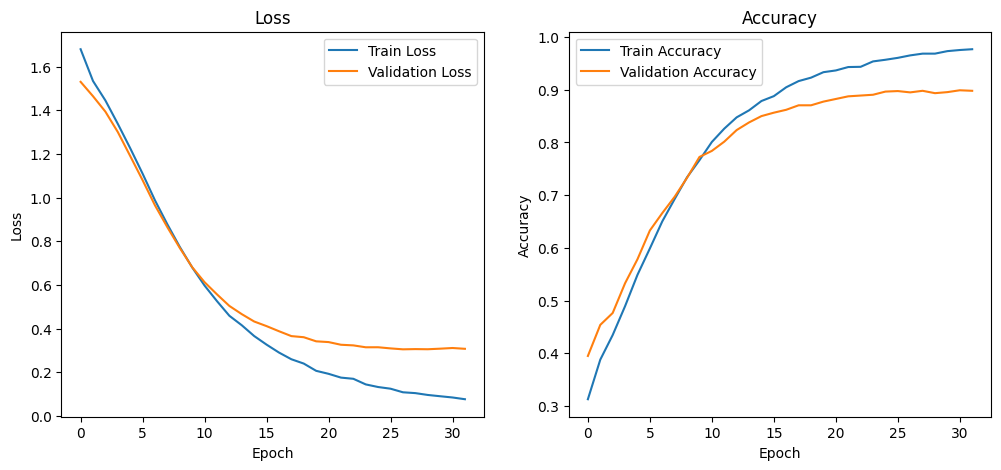

Test Accuracy: 0.8935
              precision    recall  f1-score   support

     sadness       0.92      0.93      0.93       581
         joy       0.91      0.93      0.92       695
        love       0.80      0.74      0.77       159
       anger       0.87      0.88      0.88       275
        fear       0.89      0.85      0.87       224
    surprise       0.79      0.68      0.73        66

    accuracy                           0.89      2000
   macro avg       0.86      0.84      0.85      2000
weighted avg       0.89      0.89      0.89      2000



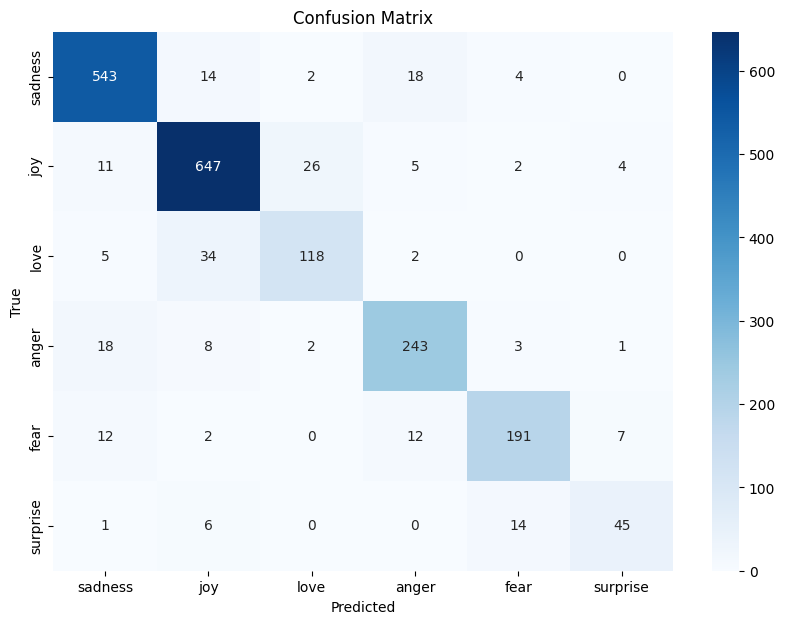

In [ ]:
import re
import torch
from torch import nn
from transformers import BertTokenizer
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from datasets import load_dataset

# Load the datasets
dataset = load_dataset("dair-ai/emotion", "split")
train_dataset = dataset['train']
val_dataset = dataset['validation']
test_dataset = dataset['test']

# Text preprocessing function
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'\s+', ' ', text).strip()
    return text

# Preprocess the train, validation, and test sets
train_texts = [preprocess_text(text) for text in train_dataset['text']]
val_texts = [preprocess_text(text) for text in val_dataset['text']]
test_texts = [preprocess_text(text) for text in test_dataset['text']]

# Labels
train_labels = train_dataset['label']
val_labels = val_dataset['label']
test_labels = test_dataset['label']

# Load BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Data encoding function
def encode_data(texts, labels, tokenizer, max_length=128):
    inputs = tokenizer(texts, padding=True, truncation=True, max_length=max_length, return_tensors="pt")
    inputs["labels"] = torch.tensor(labels)
    return inputs

# Encode the train, validation, and test sets
train_encodings = encode_data(train_texts, train_labels, tokenizer)
val_encodings = encode_data(val_texts, val_labels, tokenizer)
test_encodings = encode_data(test_texts, test_labels, tokenizer)

# Define CNN model
class CNNModel(nn.Module):
    def __init__(self, vocab_size, embed_dim, num_labels):
        super(CNNModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.conv1 = nn.Conv2d(1, 100, kernel_size=(3, embed_dim), padding=(2, 0))
        self.conv2 = nn.Conv2d(1, 100, kernel_size=(4, embed_dim), padding=(3, 0))
        self.conv3 = nn.Conv2d(1, 100, kernel_size=(5, embed_dim), padding=(4, 0))
        self.dropout = nn.Dropout(0.5)
        self.fc = nn.Linear(300, num_labels)
    def forward(self, input_ids):
        embedded = self.embedding(input_ids).unsqueeze(1)
        conv1 = torch.relu(self.conv1(embedded)).squeeze(3)
        conv2 = torch.relu(self.conv2(embedded)).squeeze(3)
        conv3 = torch.relu(self.conv3(embedded)).squeeze(3)
        pool1 = torch.max_pool1d(conv1, conv1.size(2)).squeeze(2)
        pool2 = torch.max_pool1d(conv2, conv2.size(2)).squeeze(2)
        pool3 = torch.max_pool1d(conv3, conv3.size(2)).squeeze(2)
        out = torch.cat([pool1, pool2, pool3], 1)
        out = self.dropout(out)
        logits = self.fc(out)
        return logits

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cuda")

# Get the vocabulary size
vocab_size = tokenizer.vocab_size

# Define the model
model = CNNModel(vocab_size, embed_dim=128, num_labels=6)
model.to(device)  # Move model to GPU

# Define dataset class
class EmotionDataset(torch.utils.data.Dataset):
    def __init__(self, encodings):
        self.encodings = encodings
    def __getitem__(self, idx):
        return {key: val[idx] for key, val in self.encodings.items()}
    def __len__(self):
        return len(self.encodings['input_ids'])

# Training function
def train_model(model, train_dataset, val_dataset, epochs, batch_size, learning_rate, patience):
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size)

    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    best_val_loss = float('inf')
    patience_counter = 0

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        correct = 0
        total = 0

        for batch in train_loader:
            input_ids = batch['input_ids'].to(device)
            labels = batch['labels'].to(device)

            optimizer.zero_grad()
            outputs = model(input_ids)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_loss = total_loss / len(train_loader)
        train_accuracy = correct / total
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)

        model.eval()
        val_loss = 0
        correct = 0
        total = 0

        with torch.no_grad():
            for batch in val_loader:
                input_ids = batch['input_ids'].to(device)
                labels = batch['labels'].to(device)
                outputs = model(input_ids)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        val_loss = val_loss / len(val_loader)
        val_accuracy = correct / total
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")

        # Early stopping mechanism
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            # Save the best model
            torch.save(model.state_dict(), "best_cnn_model.pth")
        else:
            patience_counter += 1

        if patience_counter >= patience:
            print("Early stopping triggered")
            break

    # Plot loss and accuracy charts
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Loss')

    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label='Train Accuracy')
    plt.plot(val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Accuracy')

    plt.show()

# Train the model with early stopping patience set to 5
train_model(model, EmotionDataset(train_encodings), EmotionDataset(val_encodings), epochs=40, batch_size=16, learning_rate=1e-4, patience=5)

# Load the best model
model.load_state_dict(torch.load("best_cnn_model.pth"))

# Evaluation function
def evaluate_model(model, test_dataset):
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=16)
    model.eval()
    correct = 0
    total = 0
    predictions = []
    true_labels = []
    with torch.no_grad():
        for batch in test_loader:
            input_ids = batch['input_ids'].to(device)
            labels = batch['labels'].to(device)
            outputs = model(input_ids)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            predictions.extend(predicted.tolist())
            true_labels.extend(labels.tolist())
    print(f"Test Accuracy: {correct/total}")
    print(classification_report(true_labels, predictions, target_names=['sadness', 'joy', 'love', 'anger', 'fear', 'surprise']))
    # Generate confusion matrix
    cm = confusion_matrix(true_labels, predictions)
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['sadness', 'joy', 'love', 'anger', 'fear', 'surprise'], yticklabels=['sadness', 'joy', 'love', 'anger', 'fear', 'surprise'])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

# Evaluate the model on the test set
evaluate_model(model, EmotionDataset(test_encodings))


Bert

A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Pl

Step,Training Loss,Validation Loss,Accuracy
100,1.455000,1.026026,0.675000
200,0.757000,0.495680,0.846000
300,0.400600,0.298131,0.907000
400,0.291300,0.242176,0.918000
500,0.254700,0.205480,0.921500
600,0.161500,0.201835,0.930000
700,0.166400,0.168879,0.934500
800,0.144100,0.178076,0.932500
900,0.154900,0.165569,0.931500
1000,0.155500,0.150087,0.934000


Epoch 0.2: Training Accuracy: 0.6744, Training Loss: 1.4550
Validation Loss: 1.0260263681411743, Accuracy: 0.675
Epoch 0.4: Training Accuracy: 0.8602, Training Loss: 0.7570
Validation Loss: 0.49567973613739014, Accuracy: 0.846
Epoch 0.6: Training Accuracy: 0.9172, Training Loss: 0.4006
Validation Loss: 0.29813146591186523, Accuracy: 0.907
Epoch 0.8: Training Accuracy: 0.9342, Training Loss: 0.2913
Validation Loss: 0.24217644333839417, Accuracy: 0.918
Epoch 1.0: Training Accuracy: 0.9405, Training Loss: 0.2547
Validation Loss: 0.20547957718372345, Accuracy: 0.9215
Epoch 1.2: Training Accuracy: 0.9431, Training Loss: 0.1615
Validation Loss: 0.20183487236499786, Accuracy: 0.93
Epoch 1.4: Training Accuracy: 0.9500, Training Loss: 0.1664
Validation Loss: 0.16887883841991425, Accuracy: 0.9345
Epoch 1.6: Training Accuracy: 0.9547, Training Loss: 0.1441
Validation Loss: 0.17807647585868835, Accuracy: 0.9325
Epoch 1.8: Training Accuracy: 0.9543, Training Loss: 0.1549
Validation Loss: 0.16556942

Validation Loss: 0.15312457084655762, Accuracy: 0.9385
Validation Loss: 0.15312457084655762
Final Evaluation on Test Set...
Validation Loss: 0.16939523816108704, Accuracy: 0.927
Test Loss: 0.16939523816108704


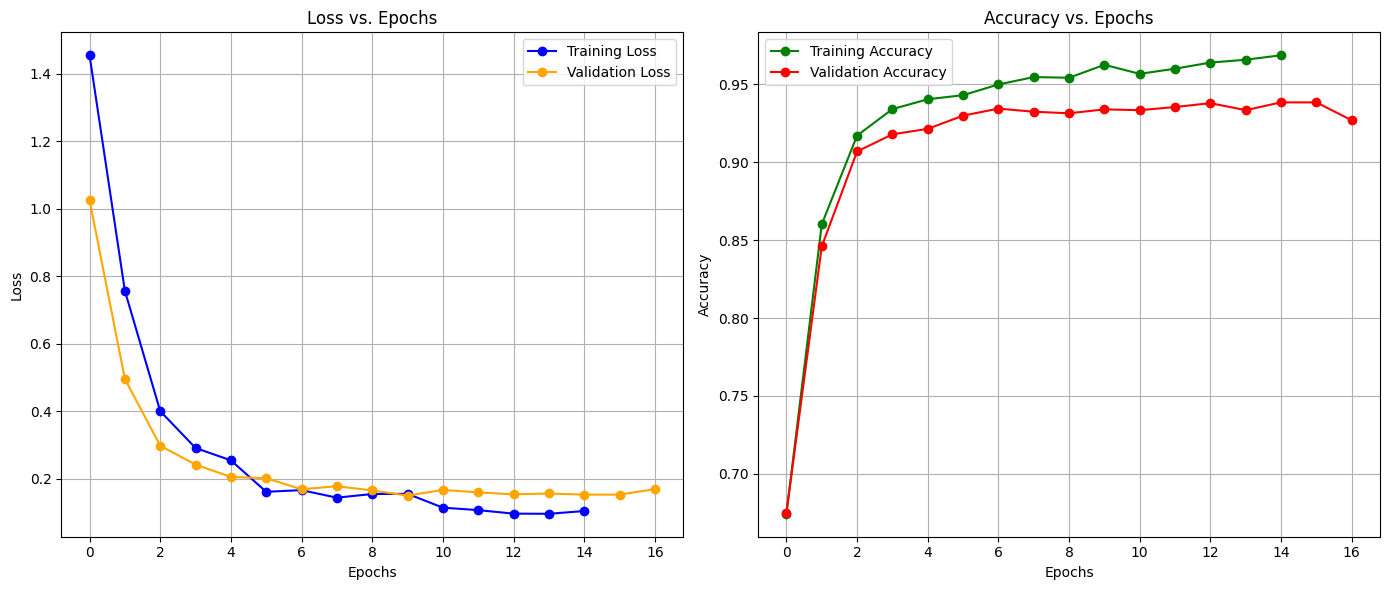

Generating classification report and confusion matrix for validation set...
              precision    recall  f1-score   support

     sadness       0.96      0.97      0.96       550
         joy       0.96      0.95      0.96       704
        love       0.90      0.86      0.88       178
       anger       0.96      0.93      0.95       275
        fear       0.86      0.94      0.90       212
    surprise       0.86      0.79      0.83        81

    accuracy                           0.94      2000
   macro avg       0.92      0.91      0.91      2000
weighted avg       0.94      0.94      0.94      2000



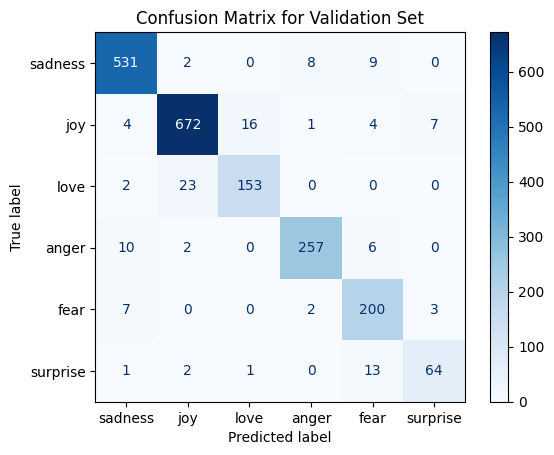

Generating classification report and confusion matrix for test set...


              precision    recall  f1-score   support

     sadness       0.96      0.97      0.96       581
         joy       0.95      0.96      0.95       695
        love       0.85      0.81      0.83       159
       anger       0.92      0.89      0.91       275
        fear       0.86      0.94      0.90       224
    surprise       0.85      0.67      0.75        66

    accuracy                           0.93      2000
   macro avg       0.90      0.87      0.88      2000
weighted avg       0.93      0.93      0.93      2000



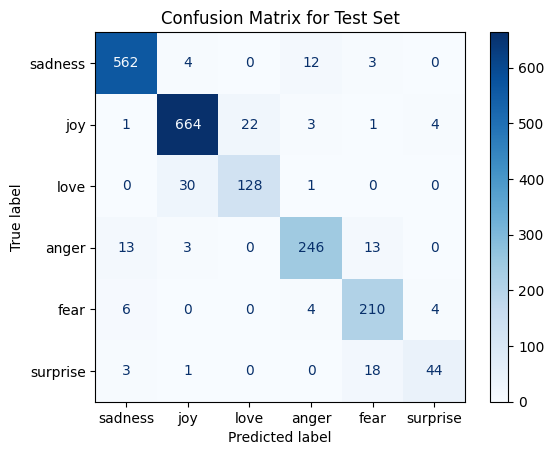

In [ ]:
import logging
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments, TrainerCallback, EarlyStoppingCallback
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import torch
import matplotlib.pyplot as plt

# Initialize logging
logging.basicConfig(filename='training_log.log', level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# Load the datasets
dataset_split = load_dataset("dair-ai/emotion", name="split")

# Load pretrained BERT model and tokenizer
model_name = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=6)

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Data preprocessing function
def preprocess_function(examples):
    return tokenizer(examples['text'], truncation=True, padding=True)

# Tokenize the datasets
tokenized_train_dataset = dataset_split['train'].map(preprocess_function, batched=True)
tokenized_validation_dataset = dataset_split['validation'].map(preprocess_function, batched=True)
tokenized_test_dataset = dataset_split['test'].map(preprocess_function, batched=True)

# Initialize lists to record metrics
epochs = []
training_losses = []
validation_losses = []
training_accuracies = []
validation_accuracies = []

# Define compute metrics function
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    acc = accuracy_score(labels, predictions)
    return {'accuracy': acc}

# Compute training metrics function
def compute_train_metrics(trainer, train_dataset):
    predictions = trainer.predict(train_dataset)
    logits = predictions.predictions
    labels = predictions.label_ids
    return compute_metrics((logits, labels))

# Logging callback
class LoggingCallback(TrainerCallback):
    def __init__(self):
        self.epoch_steps = []
    def on_log(self, args, state, control, logs=None, **kwargs):
        if logs is not None:
            epoch = state.epoch
            if epoch not in self.epoch_steps:
                self.epoch_steps.append(epoch)
                train_metrics = compute_train_metrics(trainer, trainer.train_dataset)
                training_accuracies.append(train_metrics['accuracy'])
                training_losses.append(logs['loss'])
                epochs.append(epoch)
                print(f"Epoch {epoch}: Training Accuracy: {train_metrics['accuracy']:.4f}, Training Loss: {logs['loss']:.4f}")
            if 'eval_loss' in logs and 'eval_accuracy' in logs:
                validation_losses.append(logs['eval_loss'])
                validation_accuracies.append(logs['eval_accuracy'])
                print(f"Validation Loss: {logs['eval_loss']}, Accuracy: {logs['eval_accuracy']}")

# Training arguments
training_args = TrainingArguments(
    output_dir='./results',
    evaluation_strategy="steps",
    eval_steps=100,
    save_steps=500,
    logging_steps=100,
    learning_rate=2e-5,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    num_train_epochs=3,
    weight_decay=0.01,
    report_to="none",
    disable_tqdm=False,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    save_total_limit=1  # Only keep the best model to save disk space
)

# Initialize Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train_dataset,
    eval_dataset=tokenized_validation_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

# Add callbacks
trainer.add_callback(LoggingCallback())
trainer.add_callback(EarlyStoppingCallback(early_stopping_patience=3))

# Train the model
try:
    trainer.train()
except Exception as e:
    logging.error(f"Training failed: {e}")

# Save the best model
trainer.save_model("best_model")

# Evaluate on validation set
print("Evaluating...")
eval_results = trainer.evaluate(eval_dataset=tokenized_validation_dataset)
print(f"Validation Loss: {eval_results['eval_loss']}")

# Evaluate on test set
print("Final Evaluation on Test Set...")
test_results = trainer.evaluate(eval_dataset=tokenized_test_dataset)
print(f"Test Loss: {test_results['eval_loss']}")

# Plot loss and accuracy
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(range(len(training_losses)), training_losses, marker='o', label='Training Loss', color='blue')
plt.plot(range(len(validation_losses)), validation_losses, marker='o', label='Validation Loss', color='orange')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss vs. Epochs')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(range(len(training_accuracies)), training_accuracies, marker='o', label='Training Accuracy', color='green')
plt.plot(range(len(validation_accuracies)), validation_accuracies, marker='o', label='Validation Accuracy', color='red')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Epochs')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.savefig('loss_accuracy_comparison.png')
plt.show()

# Classification report and confusion matrix on validation set
print("Generating classification report and confusion matrix for validation set...")
predictions = trainer.predict(tokenized_validation_dataset)
report = classification_report(predictions.label_ids, np.argmax(predictions.predictions, axis=1), target_names=['sadness', 'joy', 'love', 'anger', 'fear', 'surprise'])
print(report)

cm = confusion_matrix(predictions.label_ids, np.argmax(predictions.predictions, axis=1))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['sadness', 'joy', 'love', 'anger', 'fear', 'surprise'])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix for Validation Set')
plt.show()

# Classification report and confusion matrix on test set
print("Generating classification report and confusion matrix for test set...")
test_predictions = trainer.predict(tokenized_test_dataset)
test_report = classification_report(test_predictions.label_ids, np.argmax(test_predictions.predictions, axis=1), target_names=['sadness', 'joy', 'love', 'anger', 'fear', 'surprise'])
print(test_report)

test_cm = confusion_matrix(test_predictions.label_ids, np.argmax(test_predictions.predictions, axis=1))
test_disp = ConfusionMatrixDisplay(confusion_matrix=test_cm, display_labels=['sadness', 'joy', 'love', 'anger', 'fear', 'surprise'])
test_disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix for Test Set')
plt.show()


# Results

After all the models were trained, we compared the results of the four models. In terms of the accuracy of different emotion categories, Bert model has the best score in the other 5 categories except for the Fear category, which is slightly inferior to the CNN model.

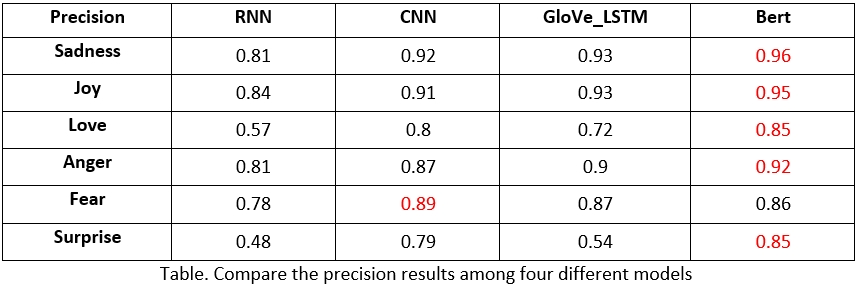

In addition, we also tried to compare the accuracy of different models on the test data set. As shown in the figure below, the performance of RNN is still the least impressive only 0.79, while the performance of CNN and GloVe is almost 0.89 and 0.88 respectively. Finally, the performance of Bert model is the best, reaching 0.93.

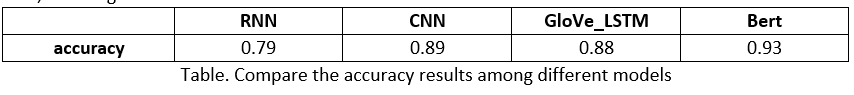